# Multi-label fine-tuned ClinicalBert, using ChatGPT Summarization

#### Necessary Imports
Please use:  
pip install pandas, tensorflow, transformers, numpy, nltk, matplotlib  
If you do not have any of the packages

In [1]:
import model_helpers
import chatGPT_helpers
import utils
import pickle
LABELS = ["ABDOMINAL",
        "ADVANCED-CAD",
        "ALCOHOL-ABUSE",
        "ASP-FOR-MI",
        "CREATININE",
        "DIETSUPP-2MOS",
        "DRUG-ABUSE",
        "ENGLISH",
        "HBA1C",
        "KETO-1YR",
        "MAJOR-DIABETES",
        "MAKES-DECISIONS",
        "MI-6MOS"]


c:\Users\nlabu\anaconda3\envs\tfenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\nlabu\anaconda3\envs\tfenv\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


### Retrieving Data

In [2]:
# Both will be dataframes with a 'notes' column and a column for each label
train_data = utils.get_note_data(LABELS, folder_name='train')
test_data = utils.get_note_data(LABELS, folder_name='test')

## Quick Data Exploration

Remember how the data were too large to pass into BERT without significant truncation? Well, we can have ChatGPT extract the important data from the notes, then have ClinicalBERT learn on this data extraction.  

Here is a quick reminder of the size of the data:

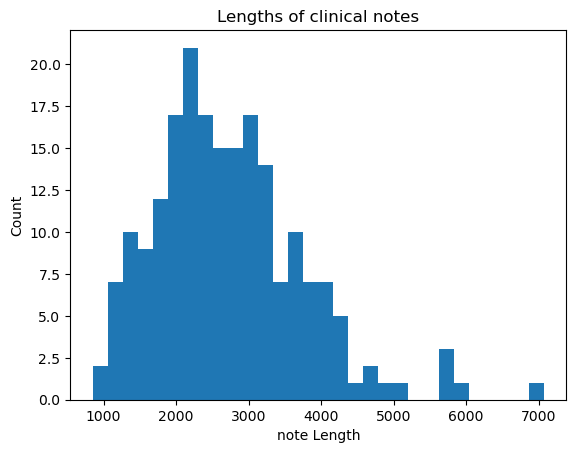

In [3]:
utils.display_histogram(train_data)

Again, these are much too long to pass into BERT, which has a max_token count of 512. However, ChatGPT's max_token count is 4096. Thus, after removing stop words, almost every note fits within this limit.

### Remaking the Data

In [10]:
# # Don't run unless you want $$ charge
# new_train_notes = chatGPT_helpers.summarize_and_save_notes(list(train_data['notes']), name='train')
# new_test_notes = chatGPT_helpers.summarize_and_save_notes(list(test_data['notes']), name='test')

In [7]:
with open('summarized_notes_train.pkl', 'rb') as f:
    # Load the object from the file
    new_train_notes = pickle.load(f)
train_data['notes'] = new_train_notes

with open('summarized_notes_test.pkl', 'rb') as f:
    # Load the object from the file
    new_test_notes = pickle.load(f)
test_data['notes'] = new_test_notes

In [9]:
test_data.head()

,notes,ABDOMINAL,ADVANCED-CAD,ALCOHOL-ABUSE,ASP-FOR-MI,CREATININE,DIETSUPP-2MOS,DRUG-ABUSE,ENGLISH,HBA1C,KETO-1YR,MAJOR-DIABETES,MAKES-DECISIONS,MI-6MOS
108,1. DRUG-ABUSE: No information provided regardi...,1,1,0,1,0,1,0,1,0,0,0,1,1
115,1. DRUG-ABUSE: No indication of current or pas...,1,0,0,1,1,1,0,1,1,0,1,1,0
118,"1. There is no mention of drug abuse, current ...",1,1,0,1,0,1,0,0,0,0,0,1,0
119,1. DRUG-ABUSE: No current or past drug abuse n...,0,0,0,1,0,0,0,1,0,0,0,1,0
120,1. No history of drug abuse\n2. No current alc...,0,0,0,1,0,0,0,1,0,0,0,1,0


### Making the models (same as before, different data now)

In [11]:
model, history = model_helpers.create_multi_label(train_data, num_epochs=20)

c:\Users\nlabu\anaconda3\envs\tfenv\lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/20


### Hyperparameter Tuning

__The history was saved so that the hyper-parameter tuning need not be done again.__

This was performed for this model as well, with similar results for epoch choice.

In [ ]:
# Save history to a pickle file
with open(f'summarize_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

In [ ]:
# TODO: Create graph for hyperparameter tuning for both labels
# Load history from the pickle file
with open(f'summarize_history.pkl', 'rb') as file:
    history = pickle.load(file)


30


KeyError: 'accuracy'

In [ ]:
# TODO: Create a graph for the history of the multi-label model
utils.make_history_graph(history)

### Evaluating the Model

In [ ]:
predictions = model_helpers.get_predictions(model, test_data)
label_to_predictions = {}
# Simple column extraction to format correclty for helper function in next cell
for label, column in zip(LABELS, range(predictions.shape[1])):
    column_values = predictions[:, column]
    label_to_predictions[label] = column_values

NameError: name 'test_data' is not defined

Save predictions and load predictions here if wanted.

In [ ]:
utils.save_preds(label_to_predictions, "summary_models_predicitions")

In [ ]:
label_to_predictions = utils.read_preds("summary_models_predicitions")

C:\Users\nlabu\AppData\Local\Temp\ipykernel_12508\2251726497.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label_to_predictions[row[0]] = list(row[1:])


### Performance:

In [ ]:

label_to_micro_f1, overall_f1 = utils.get_f1_scores_for_labels(LABELS, test_data, label_to_predictions)
print('overall-f1:', overall_f1)

Raw f1 for ABDOMINAL 0.18023255813953487
Raw f1 for ADVANCED-CAD 0.1313131313131313
Raw f1 for ALCOHOL-ABUSE 0.48809523809523814
Raw f1 for ASP-FOR-MI 0.4476744186046512
Raw f1 for CREATININE 0.381294964028777
Raw f1 for DIETSUPP-2MOS 0.7235294117647059
Raw f1 for DRUG-ABUSE 0.4787878787878788
Raw f1 for ENGLISH 0.48255813953488375
Raw f1 for HBA1C 0.1511627906976744
Raw f1 for KETO-1YR 0.5
Raw f1 for MAJOR-DIABETES 0.26744186046511625
Raw f1 for MAKES-DECISIONS 0.4883720930232558
Raw f1 for MI-6MOS 0.46249999999999997
overall-f1: 0.39868942188114215
